<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/Matrix_approach/Matrix_factorization23_04_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#path = '/content/drive/MyDrive/AdvancedBA/Olie_data/archive' #adjust this one to yours
path ='/content/drive/MyDrive/olist_project'
customers = pd.read_csv(path +'/olist_customers_dataset.csv')
reviews = pd.read_csv(path+'/olist_order_reviews_dataset.csv')
geolocation = pd.read_csv(path+'/olist_geolocation_dataset.csv')
items = pd.read_csv(path + '/olist_order_items_dataset.csv')
payments  = pd.read_csv(path + '/olist_order_payments_dataset.csv')
orders= pd.read_csv(path + '/olist_orders_dataset.csv')
products = pd.read_csv(path + '/olist_products_dataset.csv')
sellers =pd.read_csv(path + '/olist_sellers_dataset.csv')
category =  pd.read_csv(path + '/product_category_name_translation.csv')

In [5]:
data = pd.merge(orders,customers,on='customer_id')
data = pd.merge(data,reviews,on='order_id')
data = pd.merge(data,items,on='order_id')
data = pd.merge(data,products,on='product_id')
data = pd.merge(data,sellers,on='seller_id')
data = pd.merge(data, category,on ='product_category_name') # I added this one to get the tra
data.shape

(111686, 36)

We have decided to proceed with the following columns:

 ***Product_id*** : This column specifies the unique id for the products sold\
 ***customer_unique_id*** : This columns provided a uniqie id for all each customer\
 ***reviews_score*** : The score given by each customer to the products they purchased \
 ***order_purchase_timestamp***: When the order for a specific porudct was placed by the customer \
 ***product_category_name_english***: The categories where the products belong to, in english for better understanding \
 ***customer_state***: Where the customers are located in the country \
 ***seller_state***: Where the sellers are located in the country\
 ***Price*** : Price of the product

In [6]:
recommender = data[['review_score','customer_state','seller_state','product_id','product_category_name_english','customer_unique_id','order_purchase_timestamp','order_delivered_customer_date','price']]

In [31]:
#Initially, in order to better understand the product_id and customer_unique_id will convert the string to unique numbers instead.

In [7]:
recommender = recommender.assign(customer_unique_id=(recommender['customer_unique_id']).astype('category').cat.codes)
recommender = recommender.assign(product_id=(recommender['product_id']).astype('category').cat.codes)

In [8]:
recommender.head()

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_purchase_timestamp,order_delivered_customer_date,price
0,4,SP,SP,17106,housewares,45758,2017-10-02 10:56:33,2017-10-10 21:25:13,29.99
1,4,SP,SP,17106,housewares,21530,2017-08-15 18:29:31,2017-08-18 14:44:43,29.99
2,5,SP,SP,17106,housewares,87936,2017-08-02 18:24:47,2017-08-07 18:30:01,29.99
3,3,SC,SP,17106,housewares,85228,2017-10-23 23:26:46,2017-11-07 18:04:59,29.99
4,1,SP,SP,23951,housewares,44958,2017-08-24 11:31:28,2017-08-28 20:12:20,46.80


In [9]:
recommender.dtypes

review_score                       int64
customer_state                    object
seller_state                      object
product_id                         int16
product_category_name_english     object
customer_unique_id                 int32
order_purchase_timestamp          object
order_delivered_customer_date     object
price                            float64
dtype: object

In [10]:
recommender.shape

(111686, 9)

In [11]:
ratings_df = recommender[['customer_unique_id','product_id','review_score']]
ratings_df

,customer_unique_id,product_id,review_score
0,45758,17106,4
1,21530,17106,4
2,87936,17106,5
3,85228,17106,3
4,44958,23951,1
...,...,...,...
111681,57240,4599,5
111682,32279,4599,5
111683,40009,22808,5
111684,38842,25855,5


In [12]:
# No null values in the dataframe
ratings_df.isnull().sum()

customer_unique_id    0
product_id            0
review_score          0
dtype: int64

In [13]:
ratings_df.describe()

,customer_unique_id,product_id,review_score
count,111686.000000,111686.000000,111686.000000
mean,47092.415128,16121.532502,4.018418
std,27143.083445,9281.381481,1.397678
min,0.000000,0.000000,1.000000
25%,23579.250000,8169.000000,4.000000
50%,47156.500000,15947.000000,5.000000
75%,70640.750000,24178.000000,5.000000
max,94087.000000,32327.000000,5.000000


In [26]:

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings_df, train_size=0.7, random_state=0) # 2/3 -training 


In [27]:
train_df

,customer_unique_id,product_id,review_score
89758,8383,15387,5
91625,44365,6702,1
37011,9538,13574,5
30641,35218,21070,5
2331,45648,2526,1
...,...,...,...
21243,19627,9524,5
45891,4599,19581,5
42613,79003,4768,5
43567,83454,8623,5


In [16]:
print("number of training samples:", train_df.shape[0])
print("number of test samples:", test_df.shape[0])

number of training samples: 78180
number of test samples: 33506


In [17]:
# function to calculate the RMSE
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

In [18]:
# function to make the boxplot
def MakeBoxplot(y_true, y_pred, title):
    data = [y_pred[y_true == (x*0.5+0.5)] for x in range(10)]
    fig = plt.figure(figsize=(5, 5))
    plt.boxplot(data)
    min_a, max_a = 0., 5.0
    plt.xlim((min_a, max_a))
    plt.ylim((min_a, max_a))
    plt.plot([min_a, max_a * 2], [min_a, max_a], ls='--', color='gray', linewidth=1.0)# x & y values of 2 points of the plot
    plt.xticks(range(12), [x*0.5 for x in range(12)])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

In [19]:
!pip install surprise

## Model Based Collaborative filtering

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from surprise import Reader, Dataset, SVD, SVDpp, NMF, KNNBaseline, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression


In [22]:
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(train_df, reader)

## Singular value decomposition (SVD)

In [92]:
# find the correct parameters for SVD through parameter tunning in training set
# #param_grid = {
#     #'n_epochs': [20], 
#     #'lr_all': [0.005, 0.05],
#     'reg_all': [0.01, 0.1],  # regularization strength
#     'n_factors':[70, 80, 90, 100, 110, 120, 130, 140, 150, 160],# no of factors
#     #'biased': [True, False]
# #}
param_grid = {'n_factors': [70, 80, 90, 100, 110, 120, 130, 140, 150, 160], 'n_epochs': [100], 'reg_all': [0.1]}
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3) # cross validation 3-folds

gs_svd.fit(data_surprise)
svd = gs_svd.best_estimator['rmse']

# best RMSE score
print(gs_svd.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])

#'n_factors': list(range(0,202,5))[1:]

1.2767780258446733
{'n_factors': 130, 'n_epochs': 100, 'reg_all': 0.1}


In [ ]:
#recommender_data = (item_prediction_data_with_reviews.groupby(["customer_unique_id", "product_id"])["review_score"].agg(["mean"].reset_index())

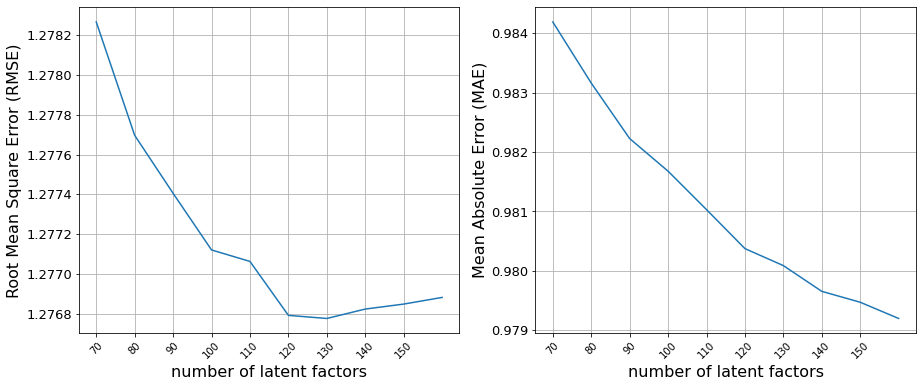

In [94]:
cv_results_svd = pd.DataFrame(gs_svd.cv_results)
fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(cv_results_svd['mean_test_rmse'])
plt.xticks(np.arange(9), np.arange(70, 160, 10), fontsize=10, rotation=45)
plt.yticks(fontsize=13)
plt.xlabel('number of latent factors', fontsize=16)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
plt.grid()

plt.subplot(122)
plt.plot(cv_results_svd['mean_test_mae'])
plt.xticks(np.arange(9), np.arange(70, 160, 10), fontsize=10, rotation=45)
plt.yticks(fontsize=13)
plt.xlabel('number of latent factors', fontsize=16)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=16)
plt.grid()

plt.show()


Now we would like to see the CV best model's proformance.

In [95]:
eval_svd = cross_validate(svd, data_surprise, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2890  1.2787  1.2805  1.2827  0.0045  
MAE (testset)     0.9878  0.9839  0.9844  0.9854  0.0017  
Fit time          21.03   20.79   21.00   20.94   0.11    
Test time         0.19    0.23    0.19    0.20    0.02    


In [96]:
y_true = test_df['review_score'].values 
y_true

array([5, 3, 3, ..., 5, 5, 1])

In [97]:
# We can now use the algorithm that yields the best rmse:
model = gs_svd.best_estimator['rmse']
model.fit(data_surprise.build_full_trainset())

In [98]:
# True values
user_ids_true = test_df['customer_unique_id'].values
product_ids_true = test_df['product_id'].values

RMSE = 0.701560369354217


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


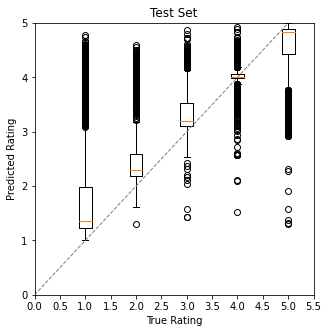

In [99]:
# check the performance
y_pred = []
for user_id, product_id in zip(user_ids_true, product_ids_true):
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    y_pred.append(r)
y_pred = np.array(y_pred)
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error) 
MakeBoxplot(y_true, y_pred, 'Test Set')

## SVD++ Model 

Improved SVD model with implicit terms.

In [100]:
param_grid = {'lr_all': [0.001, 0.003, 0.005, 0.007, 0.009], 'reg_all': [0.005, 0.01, 0.015, 0.02, 0.025]}
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs_svdpp.fit(data_surprise)
svdpp = gs_svdpp.best_estimator['rmse']
print(gs_svdpp.best_score['rmse'])
print(gs_svdpp.best_params['rmse'])

1.307631601902514
{'lr_all': 0.009, 'reg_all': 0.02}


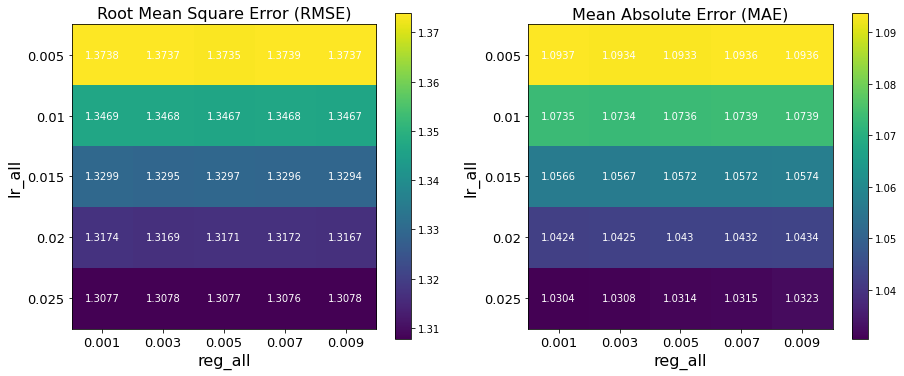

In [101]:
cv_results_svdpp = pd.DataFrame(gs_svdpp.cv_results)
svdpp_rmse = np.array(cv_results_svdpp['mean_test_rmse']).reshape(5,5)
svdpp_mae = np.array(cv_results_svdpp['mean_test_mae']).reshape(5,5)
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
im1 = ax1.imshow(svdpp_rmse)
cbar = ax1.figure.colorbar(im1, ax=ax1)
ax1.set_xticks(np.arange(5))
ax1.set_yticks(np.arange(5))
ax1.set_xticklabels(param_grid['lr_all'], fontsize=13)
ax1.set_yticklabels(param_grid['reg_all'], fontsize=13)
for i in range(5):
    for j in range(5):
        text = ax1.text(j, i, round(svdpp_rmse[i][j], 4), ha="center", va="center", color="w")
ax1.set_xlabel('reg_all', fontsize=16)
ax1.set_ylabel('lr_all', fontsize=16)
ax1.set_title('Root Mean Square Error (RMSE)', fontsize=16)
ax2 = plt.subplot(122)
im2 = ax2.imshow(svdpp_mae)
cbar = ax2.figure.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(5))
ax2.set_yticks(np.arange(5))
ax2.set_xticklabels(param_grid['lr_all'], fontsize=13)
ax2.set_yticklabels(param_grid['reg_all'], fontsize=13)
for i in range(5):
    for j in range(5):
        text = ax2.text(j, i, round(svdpp_mae[i][j], 4), ha="center", va="center", color="w")
ax2.set_xlabel('reg_all', fontsize=16)
ax2.set_ylabel('lr_all', fontsize=16)
ax2.set_title('Mean Absolute Error (MAE)', fontsize=16)
plt.show()

Now we would like to see the CV best model's proformance.

In [102]:
eval_svdpp = cross_validate(svdpp, data_surprise, measures=['RMSE', 'MAE'], cv=3, verbose=True)


Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3022  1.3060  1.3103  1.3062  0.0033  
MAE (testset)     1.0304  1.0303  1.0301  1.0303  0.0001  
Fit time          6.32    6.28    6.55    6.39    0.12    
Test time         0.29    0.38    0.29    0.32    0.04    


In [103]:
y_true = test_df['review_score'].values 
y_true

array([5, 3, 3, ..., 5, 5, 1])

In [104]:
model = gs_svdpp.best_estimator['rmse']
model.fit(data_surprise.build_full_trainset())

In [105]:
user_ids_true = test_df['customer_unique_id'].values
product_ids_true = test_df['product_id'].values

RMSE = 0.967925556195419


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


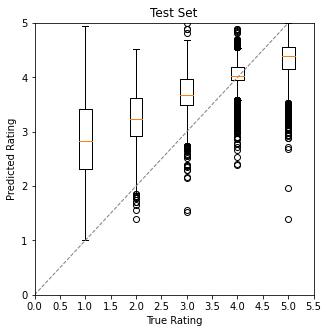

In [106]:
# check the performance
y_pred = []
for user_id, product_id in zip(user_ids_true, product_ids_true):
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    y_pred.append(r)
y_pred = np.array(y_pred)
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error) 
MakeBoxplot(y_true, y_pred, 'Test Set')

## Biased NMF (Non-negative matrix factorization)

In [ ]:
NMF model with biased term-Similar to SVD, Reduced the n_factors to avoid over-fitting.

In [107]:
param_grid = {'n_factors': [1,2,3,4,5,6,7,8,9,10], 'n_epochs': [100], 'biased': [True], 'reg_bu': [0.1], 'reg_bi': [0.1]}
gs_nmfb = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3)
gs_nmfb.fit(data_surprise)
nmfb = gs_nmfb.best_estimator['rmse']
print(gs_nmfb.best_score['rmse'])
print(gs_nmfb.best_params['rmse'])

1.4023537947377787
{'n_factors': 1, 'n_epochs': 100, 'biased': True, 'reg_bu': 0.1, 'reg_bi': 0.1}


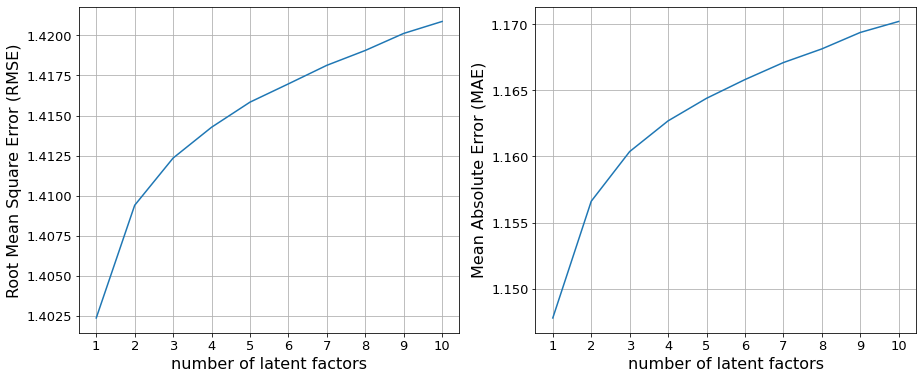

In [108]:
cv_results_nmfb = pd.DataFrame(gs_nmfb.cv_results)
fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(cv_results_nmfb['mean_test_rmse'])
plt.xticks(np.arange(10), np.arange(1, 11), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('number of latent factors', fontsize=16)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
plt.grid()

plt.subplot(122)
plt.plot(cv_results_nmfb['mean_test_mae'])
plt.xticks(np.arange(10), np.arange(1, 11), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('number of latent factors', fontsize=16)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=16)
plt.grid()

plt.show()

Now we would like to see the CV best model's proformance.

In [109]:
eval_nmfb= cross_validate(nmfb, data_surprise, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3973  1.3974  1.4031  1.3992  0.0027  
MAE (testset)     1.1423  1.1410  1.1493  1.1442  0.0036  
Fit time          9.98    9.43    9.80    9.74    0.23    
Test time         0.21    0.20    0.19    0.20    0.01    


In [110]:
y_true = test_df['review_score'].values 
y_true

array([5, 3, 3, ..., 5, 5, 1])

In [111]:
model = gs_nmfb.best_estimator['rmse']
model.fit(data_surprise.build_full_trainset())

RMSE = 0.8202042877296923


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


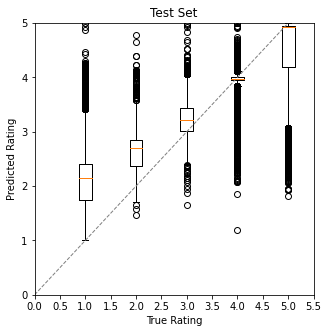

In [112]:
# check the performance
y_pred = []
for user_id, product_id in zip(user_ids_true, product_ids_true):
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    y_pred.append(r)
y_pred = np.array(y_pred)
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error) 
MakeBoxplot(y_true, y_pred, 'Test Set')

## NMF (Non-negative matrix factorization)

In [113]:
param_grid = {'n_factors': [200, 220, 240], 'n_epochs': [100]}
gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3)
gs_nmf.fit(data_surprise)
nmf = gs_nmf.best_estimator['rmse']
print(gs_nmf.best_score['rmse'])
print(gs_nmf.best_params['rmse'])

1.2787620569176195
{'n_factors': 240, 'n_epochs': 100}


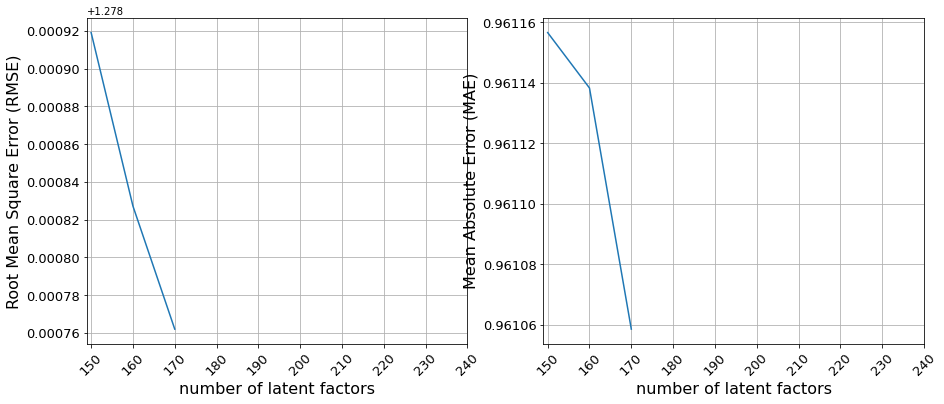

In [114]:
cv_results_nmf = pd.DataFrame(gs_nmf.cv_results)
fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(cv_results_nmf['mean_test_rmse'])
plt.xticks(np.arange(10), np.arange(150,251,10), fontsize=13,rotation=45)
plt.yticks(fontsize=13)
plt.xlabel('number of latent factors', fontsize=16)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
plt.grid()

plt.subplot(122)
plt.plot(cv_results_nmf['mean_test_mae'])
plt.xticks(np.arange(10), np.arange(150,251,10), fontsize=13,rotation=45)
plt.yticks(fontsize=13)
plt.xlabel('number of latent factors', fontsize=16)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=16)
plt.grid()

plt.show()

Now we would like to see the CV best model's proformance

In [1]:
eval_nmf = cross_validate(nmf, data_surprise, measures=['RMSE', 'MAE'], cv=3, verbose=True)

NameError: ignored

In [87]:
y_true = test_df['review_score'].values 
y_true

array([5, 3, 3, ..., 5, 5, 1])

In [88]:
model = gs_nmf.best_estimator['rmse']
model.fit(data_surprise.build_full_trainset())

RMSE = 0.6936724153627032


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


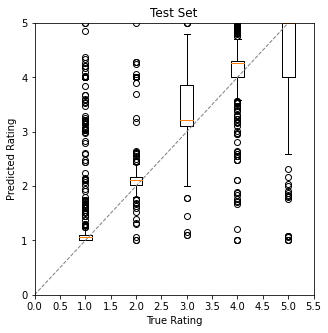

In [89]:
# check the performance
y_pred = []
for user_id, product_id in zip(user_ids_true, product_ids_true):
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    y_pred.append(r)
y_pred = np.array(y_pred)
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error) 
MakeBoxplot(y_true, y_pred, 'Test Set')

In [90]:
surprise_results = {'SVD': [np.mean(eval_svd['rmse']), np.mean(eval_svd['mae'])], 'SVDpp': [np.mean(eval_svdpp['rmse']), np.mean(eval_svdpp['mae'])],\
                    'NMF': [np.mean(eval_nmf['rmse']), np.mean(eval_nmf['mae'])], 'Biased_NMF': [np.mean(eval_nmfb['rmse']), np.mean(eval_nmfb['mae'])]
                    }
surprise_results = pd.DataFrame(surprise_results, index=['RMSE', 'MAE']).T
surprise_results

NameError: ignored

In [ ]:
# 'kNN_SGD': [np.mean(eval_knnb['rmse']), np.mean(eval_knnb['mae'])], 'kNN_ALS': [np.mean(eval_knnb_1['rmse']), np.mean(eval_knnb_1['mae'])],\
#                     'Baseline_SVM': [np.mean(rmse_svm), np.mean(mae_svm)], 'Ultimate': [np.mean(rmse_ult), np.mean(mae_ult)]

In [52]:
# from surprise import SVD, SVDpp
# from surprise import Dataset
# from surprise.model_selection import cross_validate
# #from sklearn.cross_validation import train_test_split


# #data = Dataset.load_builtin('ml-100k')
# reader = Reader(rating_scale=(1, 5))
# data_surprise = Dataset.load_from_df(train_df, reader)

# # SVD algorithm.
# algo = SVD()
# # Run 5-fold cross-validation and print results.
# cross_validate(algo, data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# # SVD++ - Singular Value Decomposition with Implicit Ratings
# #algo = SVD++()
# # Run 5-fold cross-validation and print results.
# #cross_validate(algo, data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# # Non-negative matrix factorization
# algo = NMF()
# # Run 5-fold cross-validation and print results.
# cross_validate(algo, data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3146  1.3041  1.3001  1.2894  1.3017  1.3020  0.0081  
MAE (testset)     1.0385  1.0317  1.0318  1.0211  1.0318  1.0310  0.0056  
Fit time          4.54    4.47    4.51    4.51    4.55    4.52    0.03    
Test time         0.13    0.15    0.14    0.25    0.13    0.16    0.05    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2653  1.2736  1.2742  1.2822  1.2602  1.2711  0.0077  
MAE (testset)     0.9548  0.9615  0.9586  0.9701  0.9555  0.9601  0.0055  
Fit time          11.39   11.35   11.62   11.50   11.57   11.49   0.10    
Test time         0.13    0.12    0.12    0.12    0.25    0.15    0.05    


{'fit_time': (11.386592388153076,
  11.353320121765137,
  11.616589069366455,
  11.503989219665527,
  11.570087909698486),
 'test_mae': array([0.95480652, 0.96154869, 0.95857552, 0.97005187, 0.9555314 ]),
 'test_rmse': array([1.26530281, 1.27358608, 1.27417648, 1.28224076, 1.26017069]),
 'test_time': (0.13323330879211426,
  0.121185302734375,
  0.12466955184936523,
  0.12285614013671875,
  0.24943947792053223)}

###KNN -Stochastic Gradient Descent (SGD) baseline prediction.

In [ ]:
param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'sim_options': {'user_based': [True, False]},\
              'bsl_options': {'method': ['als', 'sgd']}}
gs_knn = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs_knn.fit(data)
print(gs_knn.best_score['rmse'])
print(gs_knn.best_params['rmse'])

In [ ]:
cv_results_knn = pd.DataFrame(gs_knn.cv_results)
index = np.arange(0, 40, 4)
fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(cv_results_knn.loc[index, 'mean_test_rmse'].tolist(), label='user_based_als')
plt.plot(cv_results_knn.loc[index+1, 'mean_test_rmse'].tolist(), label='user_based_sgd')
plt.plot(cv_results_knn.loc[index+2, 'mean_test_rmse'].tolist(), label='item_based_als')
plt.plot(cv_results_knn.loc[index+3, 'mean_test_rmse'].tolist(), label='item_based_sgd')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index, 'mean_test_rmse'].tolist(), cv_results_knn.loc[index, 'std_test_rmse'].tolist(), capsize=8, label='user_based_als')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+1, 'mean_test_rmse'].tolist(), cv_results_knn.loc[index+1, 'std_test_rmse'].tolist(), capsize=8, label='user_based_sgd')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+2, 'mean_test_rmse'].tolist(), cv_results_knn.loc[index+2, 'std_test_rmse'].tolist(), capsize=8, label='item_based_als')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+3, 'mean_test_rmse'].tolist(), cv_results_knn.loc[index+3, 'std_test_rmse'].tolist(), capsize=8, label='item_based_sgd')
plt.xticks(np.arange(10), np.arange(10, 110, 10), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('number of neighbors (k)', fontsize=16)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(cv_results_knn.loc[index, 'mean_test_mae'].tolist(), label='user_based_als')
plt.plot(cv_results_knn.loc[index+1, 'mean_test_mae'].tolist(), label='user_based_sgd')
plt.plot(cv_results_knn.loc[index+2, 'mean_test_mae'].tolist(), label='item_based_als')
plt.plot(cv_results_knn.loc[index+3, 'mean_test_mae'].tolist(), label='item_based_sgd')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index, 'mean_test_mae'].tolist(), cv_results_knn.loc[index, 'std_test_mae'].tolist(), capsize=8, label='user_based_als')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+1, 'mean_test_mae'].tolist(), cv_results_knn.loc[index+1, 'std_test_mae'].tolist(), capsize=8, label='user_based_sgd')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+2, 'mean_test_mae'].tolist(), cv_results_knn.loc[index+2, 'std_test_mae'].tolist(), capsize=8, label='item_based_als')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+3, 'mean_test_mae'].tolist(), cv_results_knn.loc[index+3, 'std_test_mae'].tolist(), capsize=8, label='item_based_sgd')
plt.xticks(np.arange(10), np.arange(10, 110, 10), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('number of neighbors (k)', fontsize=16)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=16)
plt.grid()
plt.legend()
plt.show()

In [ ]:
from surprise import KNNBasic

algo = KNNBasic()
cross_validate(algo, data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...


## cosine distance

In [ ]:
ratings_df

## Baselines

We will use 4 baseline models:
1. Global mean
2. User's mean
3. Movie's mean
4. Global mean + deviation of user(user mean-global mean) + deviation of the movie(movie mean-global mean)

### Global Mean

In [ ]:
y_true = test_df['review_score'].values 
y_true

array([5, 4, 4, ..., 4, 5, 5])

global_mean = 4.0151445382450754
RMSE = 1.3950077964009417


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


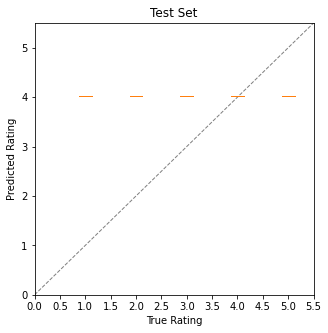

In [ ]:
global_mean = train_df['review_score'].mean() 
print("global_mean =", global_mean)
y_pred_1 = []
for i, row in test_df.iterrows():
    y_pred_1.append(global_mean)
y_pred_1 = np.array(y_pred_1)
y_pred_1 = np.clip(y_pred_1, 1.0, 5.0)
# or simply y_pred = np.array([global_mean for i in range(len(y_true))])
# performance
error = RMSE(y_true, y_pred_1)
print("RMSE =", error) # high error
MakeBoxplot(y_true, y_pred_1, 'Test Set')

### User mean

In [ ]:
train_df.groupby('customer_unique_id')['review_score'].mean()

customer_unique_id
0        5.0
1        4.0
2        3.0
3        4.0
4        5.0
        ... 
94081    5.0
94083    5.0
94084    4.0
94086    5.0
94087    5.0
Name: review_score, Length: 68545, dtype: float64

In [ ]:
test_df.head()

,customer_unique_id,product_id,review_score
53765,75532,20251,5
16517,71109,26873,4
47766,11750,592,4
24739,90490,4920,3
80782,24842,28852,1


In [ ]:
test_df[test_df['customer_unique_id']==75532]

,customer_unique_id,product_id,review_score
53765,75532,20251,5


In [ ]:
test_df.groupby('customer_unique_id')

In [ ]:
user_mean

customer_unique_id
0        5.0
1        4.0
2        3.0
3        4.0
4        5.0
        ... 
94081    5.0
94083    5.0
94084    4.0
94086    5.0
94087    5.0
Name: review_score, Length: 68545, dtype: float64

In [ ]:
# No customer like 75532 in train_df
train_df[train_df['customer_unique_id']==75532]

,customer_unique_id,product_id,review_score


In [ ]:
test_df

,customer_unique_id,product_id,review_score
53765,75532,20251,5
16517,71109,26873,4
47766,11750,592,4
24739,90490,4920,3
80782,24842,28852,1
...,...,...,...
12053,5119,2904,5
74374,24268,4574,4
56915,7594,1452,4
46709,2573,3910,5


In [ ]:
# user mean- use average of all ratings from the user x (here we get different means for different users.)
user_mean = train_df.groupby('customer_unique_id')['review_score'].mean()
y_pred_2 = []
for i, row in test_df.iterrows():
    y_pred_2.append(user_mean[row['customer_unique_id']])
y_pred_2 = np.array(y_pred_2)
y_pred_2 = np.clip(y_pred_2, 1.0, 5.0)
error = RMSE(y_true, y_pred_2)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred_2, 'Test Set')

KeyError: ignored

### product mean

In [ ]:
product_mean = train_df.groupby('product_id')['review_score'].mean()
# prediction
y_pred_3 = []
for i, row in test_df.iterrows():
    y_pred_3.append(product_mean[row['product_id']])#use movie mean(average of all ratings from the movie i) as y_pred values
y_pred_3 = np.array(y_pred_3)
y_pred_3 = np.clip(y_pred_3, 1.0, 5.0)
# performance
error = RMSE(y_true, y_pred_3)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred_3, 'Test Set')

KeyError: ignored